# Store Item Demand Forecasting Challenge

## Import von Bibliotheken und Daten

In [36]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

ModuleNotFoundError: No module named 'statsmodels'

In [2]:
df_sample_submission = pd.read_csv('./data/sample_submission.csv')
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

## Einblick in die Daten

In [3]:
df_sample_submission.head()

,id,sales
0,0,52
1,1,52
2,2,52
3,3,52
4,4,52


In [4]:
df_sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      45000 non-null  int64
 1   sales   45000 non-null  int64
dtypes: int64(2)
memory usage: 703.2 KB


In [5]:
df_train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [6]:
df_train.tail()

,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [7]:
df_train.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [9]:
df_test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [10]:
df_test.dtypes

id        int64
date     object
store     int64
item      int64
dtype: object

In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      45000 non-null  int64 
 1   date    45000 non-null  object
 2   store   45000 non-null  int64 
 3   item    45000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.4+ MB


## Object to Datetime

In [12]:
df_train["date"] = pd.to_datetime(df_train["date"]) # year, month, day

In [13]:
df_train.dtypes

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

In [14]:
df_test["date"] = pd.to_datetime(df_test["date"]) # year, month, day

In [15]:
df_test.dtypes

id                int64
date     datetime64[ns]
store             int64
item              int64
dtype: object

# Preprocessing

In [16]:
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['dayofweek'] = df_train['date'].dt.dayofweek  # Montag=0, Sonntag=6
df_train['dayofyear'] = df_train['date'].dt.dayofyear
df_train['weekofyear'] = df_train['date'].dt.isocalendar().week.astype(int)

## Preprocessing: fehlende Werte

<Axes: >

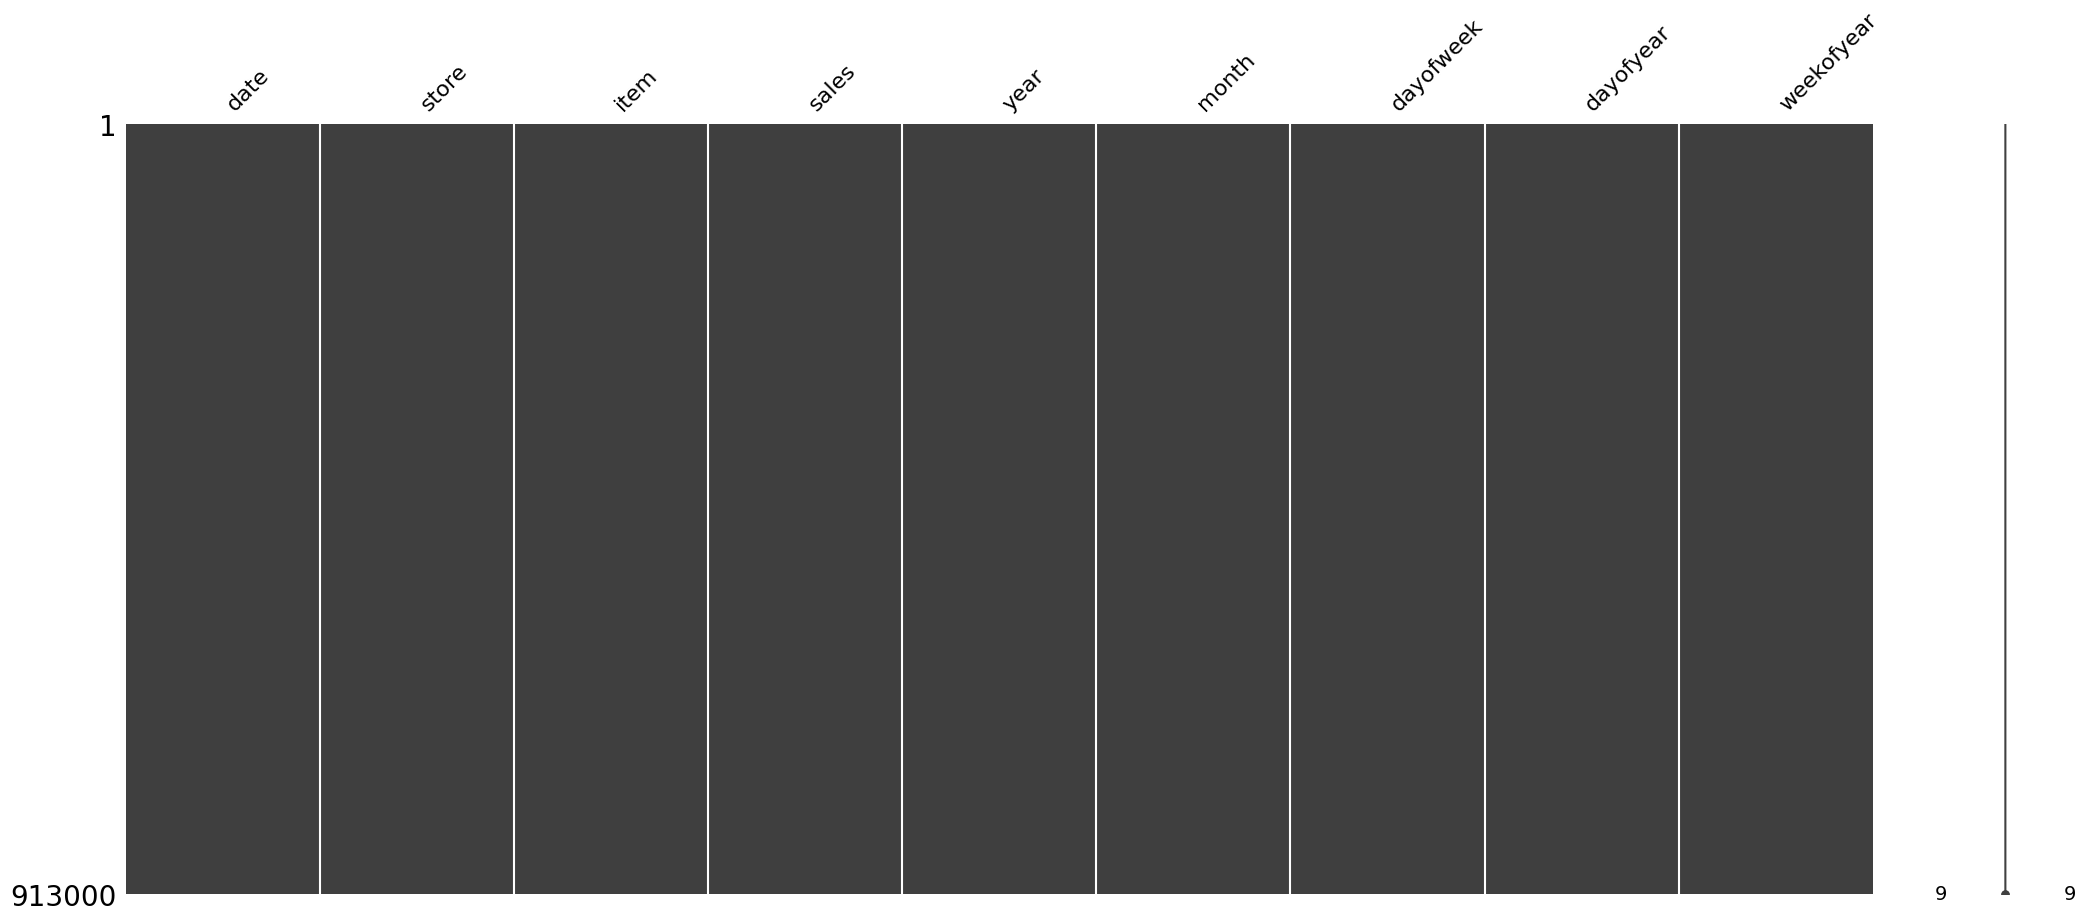

In [17]:
msno.matrix(df_train) 

<Axes: >

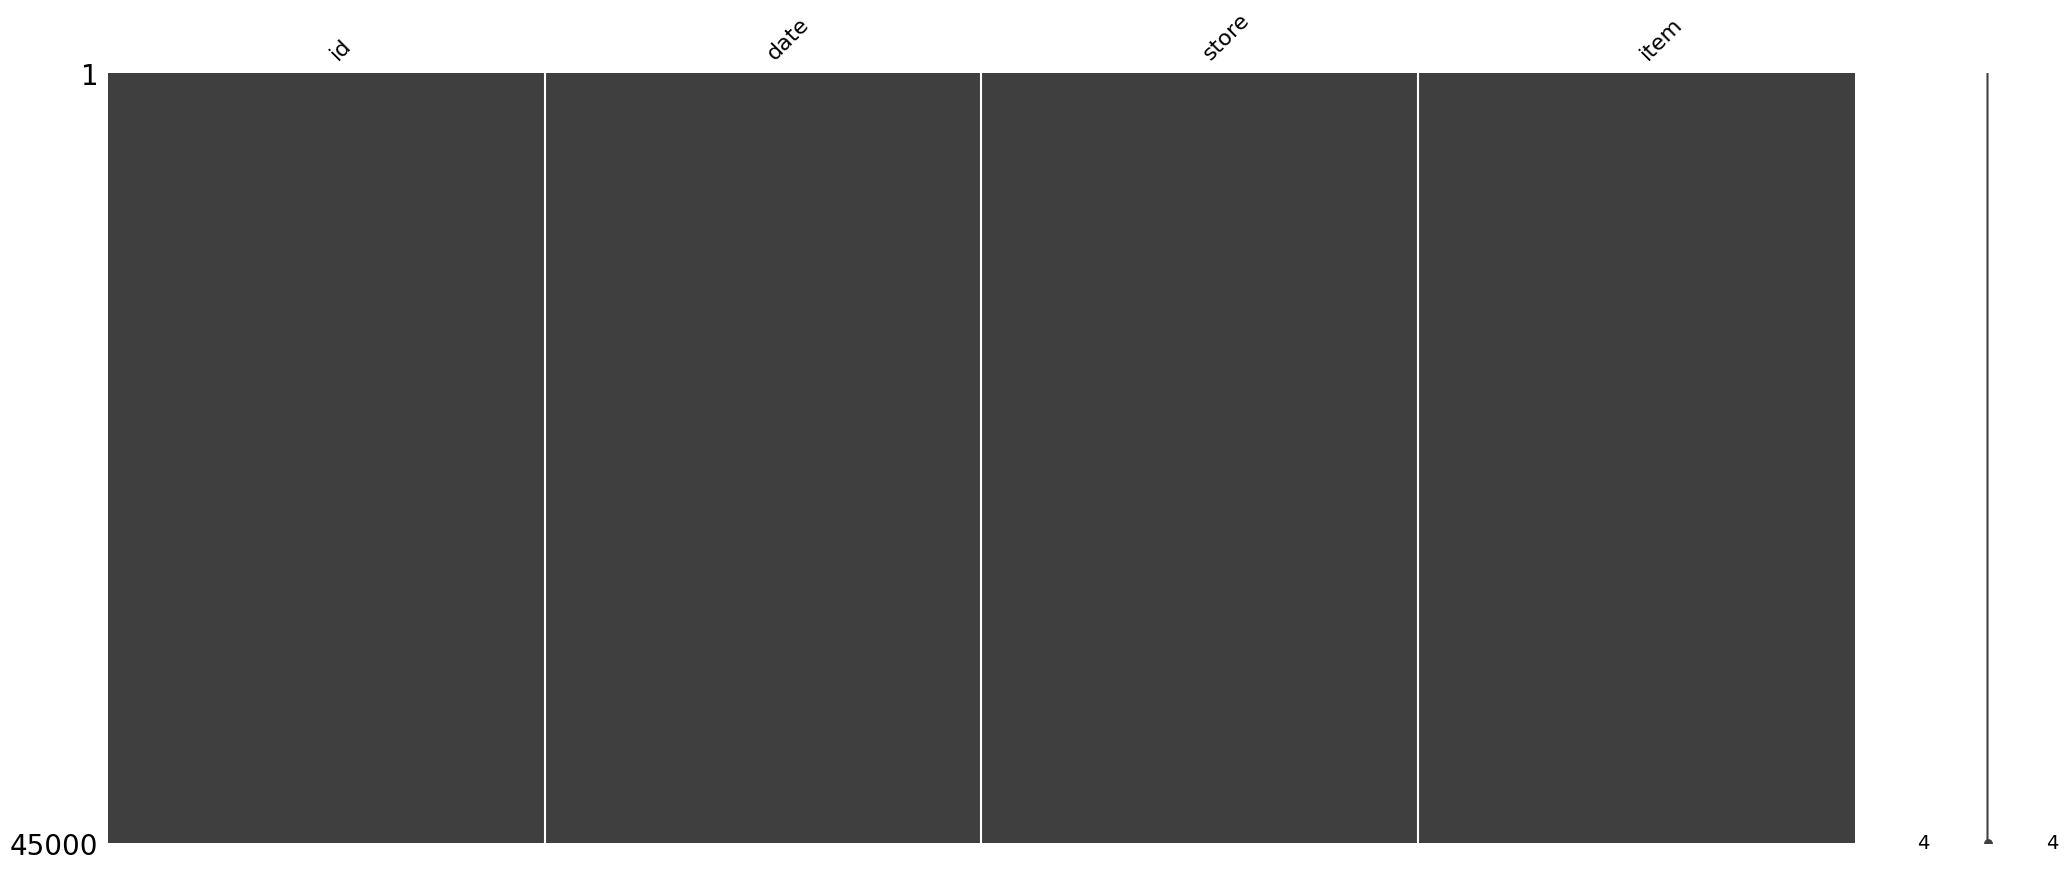

In [18]:
msno.matrix(df_test) 

# Preprocessing: Duplikate 

In [19]:
df_train[df_train.duplicated(keep=False)]

,date,store,item,sales,year,month,dayofweek,dayofyear,weekofyear


In [20]:
df_test[df_test.duplicated(keep=False)]

,id,date,store,item


# Explorative Datenanalyse

In [21]:
df_train["year"] = df_train["date"].dt.year
df_train["month"] = df_train["date"].dt.month
df_train["day"] = df_train["date"].dt.day
df_train["weekday"] = df_train["date"].dt.weekday

In [22]:
df_train

,date,store,item,sales,year,month,dayofweek,dayofyear,weekofyear,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5,1,5,5
...,...,...,...,...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,2017,12,2,361,52,27,2
912996,2017-12-28,10,50,59,2017,12,3,362,52,28,3
912997,2017-12-29,10,50,74,2017,12,4,363,52,29,4
912998,2017-12-30,10,50,62,2017,12,5,364,52,30,5


# Visualisierung des Verkaufsverlaufs über die Zeit
plt.figure(figsize=(15, 6))
plt.plot(df_train.groupby('date')['sales'].sum(), label='Gesamtverkäufe')
plt.title('Gesamtverkaufsverlauf über die Zeit')
plt.xlabel('Datum')
plt.ylabel('Verkäufe')
plt.legend()
plt.show()

# Visualisierung des Verkaufs nach Wochentag
plt.figure(figsize=(10, 5))
sns.barplot(x='dayofweek', y='sales', data=df_train, estimator=np.mean)
plt.title('Durchschnittliche Verkäufe pro Wochentag')
plt.xlabel('Wochentag (0=Mo, 6=So)')
plt.ylabel('Durchschnittlicher Verkauf')
plt.show()

# Visualisierung des Verkaufs nach Monat
plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='sales', data=df_train, estimator=np.mean)
plt.title('Durchschnittliche Verkäufe pro Monat')
plt.xlabel('Monat')
plt.ylabel('Durchschnittlicher Verkauf')
plt.show()

# Visualisierung der Verkäufe nach Jahr
plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='sales', data=df_train, estimator=np.mean)
plt.title('Durchschnittliche Verkäufe pro Jahr')
plt.xlabel('Jahr')
plt.ylabel('Durchschnittlicher Verkauf')
plt.show()

# Visualisierung der Verkäufe pro Store und Item
store_item_sales = df_train.groupby(['store', 'item'])['sales'].mean().reset_index()
fig = px.treemap(store_item_sales, path=['store', 'item'], values='sales',
                 title='Durchschnittlicher Verkauf pro Store und Item')
fig.show()

# Feature Engineering

In [23]:
for lag in [1, 7, 30]:
    df_train[f"lag_{lag}"] = df_train.groupby(["store", "item"])["sales"].shift(lag)

In [24]:
for window in [7, 30]:
    df_train[f"rolling_mean_{window}"] = (
        df_train.groupby(["store", "item"])["sales"]
        .shift(1)  
        .rolling(window=window)
        .mean()
        .reset_index(drop=True)
    )

In [25]:
df_train.head(5)

,date,store,item,sales,year,month,dayofweek,dayofyear,weekofyear,day,weekday,lag_1,lag_7,lag_30,rolling_mean_7,rolling_mean_30
0,2013-01-01,1,1,13,2013,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11,2013,1,2,2,1,2,2,13.0,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14,2013,1,3,3,1,3,3,11.0,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13,2013,1,4,4,1,4,4,14.0,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10,2013,1,5,5,1,5,5,13.0,NaN,NaN,NaN,NaN


In [26]:
df_train.dropna().reset_index(drop=True)
#df_train.fillna(0, inplace=True) 

,date,store,item,sales,year,month,dayofweek,dayofyear,weekofyear,day,weekday,lag_1,lag_7,lag_30,rolling_mean_7,rolling_mean_30
0,2013-01-31,1,1,13,2013,1,3,31,5,31,3,9.0,8.0,13.0,10.285714,10.500000
1,2013-02-01,1,1,11,2013,2,4,32,5,1,4,13.0,14.0,11.0,11.000000,10.500000
2,2013-02-02,1,1,21,2013,2,5,33,5,2,5,11.0,12.0,14.0,10.571429,10.500000
3,2013-02-03,1,1,15,2013,2,6,34,5,3,6,21.0,12.0,13.0,11.857143,10.733333
4,2013-02-04,1,1,14,2013,2,0,35,6,4,0,15.0,11.0,10.0,12.285714,10.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897995,2017-12-27,10,50,63,2017,12,2,361,52,27,2,41.0,51.0,75.0,61.000000,64.633333
897996,2017-12-28,10,50,59,2017,12,3,362,52,28,3,63.0,63.0,68.0,62.714286,64.233333
897997,2017-12-29,10,50,74,2017,12,4,363,52,29,4,59.0,75.0,76.0,62.142857,63.933333
897998,2017-12-30,10,50,62,2017,12,5,364,52,30,5,74.0,70.0,73.0,62.000000,63.866667


# Training

## Train - Test Split

In [27]:
features = ['year', 'month', 'dayofweek', 'dayofyear', 'weekofyear', 'store', 'item']
target = 'sales'

In [28]:
# Trainingset 2013 to 2017
X_train = df_train.loc[df_train["date"].lt("2017-01-01")].copy()
y_train = X_train["sales"].copy()

In [29]:
# Validationset only 2017
X_test = df_train.loc[df_train["date"].ge("2017-01-01")].copy()
y_test = X_test["sales"].copy()

In [30]:
y_train = X_train[target]
y_test = X_test[target]

X_train = X_train[features]
X_test = X_test[features]

## Modelltraining mit Validierung

In [31]:
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

## Prediction and Evaluation 

In [32]:
# Prognose für die Testdaten
y_pred = gbr.predict(X_test)

# Berechnen des RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 18.732100802195486


# Training auf allen Daten

In [ ]:
X_train_full = df_train.copy()
y_train_full = df_train["sales"].copy()